In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import (
    classification_report,
    plot_confusion_matrix,
    plot_roc_curve,
    accuracy_score,
    f1_score,
)
from sklearn.model_selection import(
    train_test_split, 
    cross_val_predict,
    KFold,
    GridSearchCV,
)

from sklearn.preprocessing import normalize

#utils
from utils.num import Num
from utils.run_models import RunModels

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn import svm

In [3]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

In [4]:
def grid_Search(kf, model, params, X, y):
  accuracies_list = list()
  f1_list = list()
  for fold, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        grid = GridSearchCV(estimator=model, param_grid=params,
                            scoring='accuracy', cv=5, refit=True)
        
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average=None)
    
        print(f"Fold {fold} -> Accuracy: {acc:.3f}; F1-Scores: {f1}")
        print("Melhor parametro:", grid.best_params_)         
        
        accuracies_list.append(acc)
        f1_list.append(f1)
    
    
  accuracies = np.array(accuracies_list)
  f1s = np.array(f1_list)

  print(f"Accuracy mean (std): {accuracies.mean():.3f} ({accuracies.std():.3f})")
  print(f"F1-Score mean (std): {f1s.mean():.3f} ({f1s.std():.3f})")


In [5]:
# loading data
raw_data = loadarff('mnist_784.arff')
df = pd.DataFrame(raw_data[0])

In [6]:
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'4'
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'9'


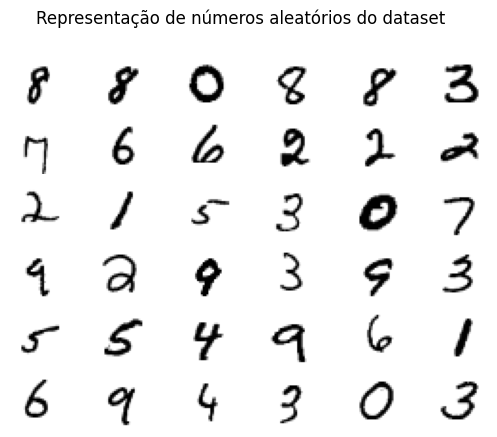

In [7]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(1000, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                 dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


Text(0.5, 1.0, 'Frequência de cada número (classe)')

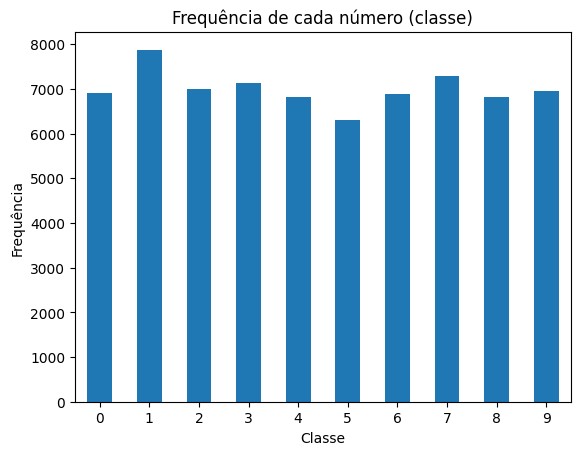

In [8]:
# numbers distribution
n_dist = df['class'].value_counts().sort_index()
n_dist.index = n_dist.index.astype('int')

fig = n_dist.plot.bar()
fig.set_xticklabels(fig.get_xticklabels(), rotation=0)
fig.set_xlabel('Classe')
fig.set_ylabel('Frequência')

fig.set_title('Frequência de cada número (classe)')

In [9]:
# treino e teste
X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

kf = KFold(n_splits=10, shuffle=True)

### KNN

In [10]:
model = KNeighborsClassifier()
parameters = {'n_neighbors': [3, 5, 7],
             'metric': ['euclidean', 'manhattan'],
}

grid_Search(kf, model, parameters, X_train, y_train)

KeyboardInterrupt: 

### Logistic Regression (?)

In [11]:
# LR = LogisticRegression()
# lr_params = {
#     'C': [100.0, 10.0, 1.0, 1e-1],
#     'class_weight': [None, 'balanced'],
#     'solver': ['sag', 'saga'],
#     'max_iter': [1000],
#     'n_jobs': [-1],
# }
# grid_Search(kf, LR, lr_params, X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### Decision Tree

In [ ]:
DT = DecisionTreeClassifier()
dt_params = {
    'min_samples_split': [10, 30],
    'max_depth':[5, 30],
    'max_features':[10, 30, 'sqrt'],
}
grid_Search(kf, DT, dt_params, X_train, y_train)

Fold 0 -> Accuracy: 0.824; F1-Scores: [0.90679305 0.94707128 0.7875895  0.74664562 0.81060016 0.72630647
 0.84995945 0.87898089 0.75515251 0.80688038]
Melhor parametro: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 10}
Fold 1 -> Accuracy: 0.838; F1-Scores: [0.90760425 0.94267516 0.82602118 0.77175698 0.79704191 0.77396022
 0.86783439 0.88625262 0.77276746 0.79625293]
Melhor parametro: {'max_depth': 30, 'max_features': 30, 'min_samples_split': 10}
Fold 2 -> Accuracy: 0.828; F1-Scores: [0.88978278 0.94969819 0.8174727  0.77647059 0.81020734 0.74666667
 0.86900958 0.86795491 0.74682472 0.77606838]
Melhor parametro: {'max_depth': 30, 'max_features': 30, 'min_samples_split': 10}
Fold 3 -> Accuracy: 0.836; F1-Scores: [0.90542636 0.93704246 0.81748466 0.75987362 0.81266039 0.77946128
 0.88962656 0.87538462 0.74337748 0.82361963]
Melhor parametro: {'max_depth': 30, 'max_features': 30, 'min_samples_split': 10}
Fold 4 -> Accuracy: 0.825; F1-Scores: [0.9122807  0.94194485 0.78328

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.123140,0.003053,0.013312,0.000572,5,10,10,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.511287,0.528571,0.486067,0.521517,0.497090,0.508907,0.015574,12
1,0.124788,0.002091,0.012977,0.000091,5,10,30,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.504674,0.530335,0.483774,0.522663,0.533686,0.515026,0.018573,11
2,0.178109,0.003089,0.013352,0.000458,5,30,10,"{'max_depth': 5, 'max_features': 30, 'min_samp...",0.598148,0.578219,0.604586,0.578924,0.591005,0.590176,0.010406,7
3,0.177370,0.003473,0.012947,0.000020,5,30,30,"{'max_depth': 5, 'max_features': 30, 'min_samp...",0.534480,0.538713,0.583510,0.580511,0.614374,0.570317,0.030007,10
4,0.170459,0.002343,0.012954,0.000049,5,sqrt,10,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.572663,0.595767,0.583510,0.566755,0.605115,0.584762,0.014195,8
5,0.170296,0.001716,0.012965,0.000041,5,sqrt,30,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.583333,0.573104,0.529189,0.577160,0.621605,0.576878,0.029430,9
6,0.201499,0.002173,0.014924,0.000112,30,10,10,"{'max_depth': 30, 'max_features': 10, 'min_sam...",0.784921,0.783245,0.796120,0.795503,0.777160,0.787390,0.007348,5
7,0.196767,0.007609,0.014972,0.000420,30,10,30,"{'max_depth': 30, 'max_features': 10, 'min_sam...",0.781658,0.767196,0.779630,0.769929,0.777954,0.775273,0.005670,6
8,0.400532,0.008259,0.014697,0.000198,30,30,10,"{'max_depth': 30, 'max_features': 30, 'min_sam...",0.834392,0.833774,0.826720,0.823457,0.814991,0.826667,0.007167,2
9,0.387514,0.008533,0.014517,0.000028,30,30,30,"{'max_depth': 30, 'max_features': 30, 'min_sam...",0.810670,0.822751,0.819048,0.817196,0.815256,0.816984,0.004010,3


### Naive Bayes

#### Gaussian NB

In [ ]:
GNB = GaussianNB()
gnb_params = {
    
}

grid_Search(kf, GNB, gnb_params, X_train, y_train)

Fold 0 -> Accuracy: 0.555; F1-Scores: [0.79620161 0.87139108 0.38386308 0.47207587 0.25101215 0.06301824
 0.75979772 0.45061043 0.39759639 0.56238185]
Melhor parametro: {}
Fold 1 -> Accuracy: 0.561; F1-Scores: [0.81355932 0.85452163 0.42167256 0.45125958 0.25414365 0.05376344
 0.77022654 0.44977169 0.42714571 0.53615023]
Melhor parametro: {}
Fold 2 -> Accuracy: 0.564; F1-Scores: [0.81546811 0.85040431 0.45894263 0.45632066 0.24460432 0.08067227
 0.75852843 0.44736842 0.42342342 0.56455345]
Melhor parametro: {}
Fold 3 -> Accuracy: 0.562; F1-Scores: [0.79059829 0.87969446 0.42092457 0.45444566 0.22701149 0.07665505
 0.77447336 0.4294049  0.41300981 0.54832882]
Melhor parametro: {}
Fold 4 -> Accuracy: 0.558; F1-Scores: [0.82902299 0.8665786  0.49941928 0.49733191 0.29249012 0.06219313
 0.78144765 0.41237113 0.38964992 0.51792829]
Melhor parametro: {}
Fold 5 -> Accuracy: 0.558; F1-Scores: [0.8103321  0.8763475  0.39950372 0.39779006 0.28176796 0.06504065
 0.75700935 0.46136101 0.42305904 0

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.387525,0.004238,0.233697,0.001924,{},0.552469,0.559171,0.55679,0.550088,0.560053,0.555714,0.00385,1


#### Multinomial NB

In [ ]:
MNNB = MultinomialNB()
mnnb_params = {
    
}

grid_Search(kf, MNNB, mnnb_params, X_train, y_train)

Fold 0 -> Accuracy: 0.820; F1-Scores: [0.91225166 0.91539528 0.84399376 0.77255779 0.79340278 0.7352381
 0.88390713 0.88558952 0.69565217 0.75876879]
Melhor parametro: {}
Fold 1 -> Accuracy: 0.820; F1-Scores: [0.9017341  0.90032154 0.85061511 0.8199853  0.77758007 0.73089005
 0.89182879 0.87708168 0.68888889 0.73382353]
Melhor parametro: {}
Fold 2 -> Accuracy: 0.827; F1-Scores: [0.91428571 0.91292876 0.86377709 0.80803571 0.77081384 0.74110672
 0.90039841 0.87006579 0.71666667 0.74316109]
Melhor parametro: {}
Fold 3 -> Accuracy: 0.828; F1-Scores: [0.91987673 0.90516577 0.86509275 0.81441718 0.79245283 0.73768844
 0.90923695 0.88006483 0.69538927 0.75917278]
Melhor parametro: {}
Fold 4 -> Accuracy: 0.823; F1-Scores: [0.91368078 0.90566038 0.84236864 0.79299363 0.78761823 0.7346514
 0.89254902 0.86704271 0.72753008 0.74492754]
Melhor parametro: {}
Fold 5 -> Accuracy: 0.829; F1-Scores: [0.90596893 0.91470786 0.84210526 0.80429777 0.81129032 0.75963303
 0.88964927 0.89631534 0.69314079 0.7

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.12063,0.000469,0.021541,0.000429,{},0.820635,0.815785,0.820282,0.824427,0.844444,0.825115,0.010046,1


### Perceptron

In [ ]:
P = Perceptron()
p_params = {
    
}

grid_Search(kf, P, p_params, X_train, y_train)

Fold 0 -> Accuracy: 0.865; F1-Scores: [0.95610535 0.95070423 0.86376812 0.84641068 0.82681564 0.83360791
 0.94058577 0.87842466 0.77571009 0.77877162]
Melhor parametro: {}
Fold 1 -> Accuracy: 0.864; F1-Scores: [0.8981026  0.93557423 0.87019231 0.83176772 0.88192771 0.79627907
 0.91856678 0.89017341 0.78308536 0.80463872]
Melhor parametro: {}
Fold 2 -> Accuracy: 0.871; F1-Scores: [0.92663477 0.94978479 0.88702929 0.83487008 0.87958115 0.80415945
 0.92908367 0.89184953 0.78353909 0.80783723]
Melhor parametro: {}
Fold 3 -> Accuracy: 0.831; F1-Scores: [0.94380165 0.92439595 0.85294118 0.83798041 0.87356322 0.74181818
 0.92985318 0.88589653 0.51938895 0.73099802]
Melhor parametro: {}
Fold 4 -> Accuracy: 0.871; F1-Scores: [0.94930876 0.95788722 0.86671744 0.85243199 0.89931741 0.74738416
 0.91354246 0.90787519 0.73888889 0.84929078]
Melhor parametro: {}
Fold 5 -> Accuracy: 0.874; F1-Scores: [0.95702479 0.91924528 0.87489779 0.86146497 0.89461358 0.77190083
 0.92973856 0.91641337 0.76139818 0

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.581372,0.58816,0.018736,0.000637,{},0.860582,0.879806,0.849206,0.843386,0.887125,0.864021,0.016971,1


### SVM

In [ ]:
svm = svm.SVC()
svm_params = {
    
}

grid_Search(kf, svm, svm_params, X_train, y_train)


## Brincando com nossos números

In [ ]:
# Testando número
num = Num('imgs/oito.png', invert=True)
num.plot()

NameError: name 'Num' is not defined